In [9]:
import pandas as pd

# Load cleaned reviews
df = pd.read_csv('../cleaned_reviews.csv')  
df.dropna(subset=['review'], inplace=True)
df = df[df['review'].str.strip() != '']
df.head()


,review,rating,date,bank,source
0,very good app,1,2025-06-09,Commercial Bank of Ethiopia,Google Play
1,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play
3,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play
4,yetemeta,1,2025-06-03,Commercial Bank of Ethiopia,Google Play


In [6]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to C:\Users\Dawa
[nltk_data]     Cloud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Dawa
[nltk_data]     Cloud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Dawa
[nltk_data]     Cloud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import nltk
import os

# Ensure nltk_data folder exists at project root
nltk_data_path = os.path.abspath("../nltk_data")  #

os.makedirs(nltk_data_path, exist_ok=True)

# Force download punkt and others to that folder
nltk.download("punkt", download_dir=nltk_data_path)
nltk.download("stopwords", download_dir=nltk_data_path)
nltk.download("wordnet", download_dir=nltk_data_path)

# Tell NLTK to look there
nltk.data.path.append(nltk_data_path)


[nltk_data] Downloading package punkt to e:\Kifya\mobile-banking-app-
[nltk_data]     review-analysis\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to e:\Kifya\mobile-banking-
[nltk_data]     app-review-analysis\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to e:\Kifya\mobile-banking-
[nltk_data]     app-review-analysis\nltk_data...


In [10]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    label = 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
    return pd.Series([polarity, label])

df[['sentiment_score', 'sentiment_label']] = df['review'].apply(get_sentiment)

# Check output
df[['review', 'sentiment_score', 'sentiment_label']].head()


,review,sentiment_score,sentiment_label
0,very good app,0.910000,positive
1,what is this app problem???,0.000000,neutral
2,not functional,0.000000,neutral
3,everytime you uninstall the app you have to re...,0.234167,positive
4,yetemeta,0.000000,neutral


In [11]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Clean reviews
def preprocess(text):
    doc = nlp(str(text).lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['review'].apply(preprocess)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5)
keywords = tfidf.fit_transform(df['cleaned'])

# Add keywords column
df['keywords'] = ["; ".join([word for word in tfidf.inverse_transform(row)[0]]) for row in keywords]

df[['review', 'keywords']].head()


,review,keywords
0,very good app,good; app
1,what is this app problem???,app
2,not functional,
3,everytime you uninstall the app you have to re...,app
4,yetemeta,


In [12]:
def assign_theme(keywords):
    text = keywords.lower()
    if any(word in text for word in ['login', 'access']):
        return 'Login Issues'
    elif any(word in text for word in ['update', 'version']):
        return 'App Updates'
    elif any(word in text for word in ['slow', 'lag']):
        return 'Performance'
    elif any(word in text for word in ['design', 'interface']):
        return 'UI/UX'
    elif any(word in text for word in ['transaction', 'payment']):
        return 'Transactions'
    else:
        return 'Other'

df['theme'] = df['keywords'].apply(assign_theme)

df[['review', 'keywords', 'theme']].head()


,review,keywords,theme
0,very good app,good; app,Other
1,what is this app problem???,app,Other
2,not functional,,Other
3,everytime you uninstall the app you have to re...,app,Other
4,yetemeta,,Other


In [13]:
df.to_csv('../all_reviews_with_sentiment_and_themes.csv', index=False)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


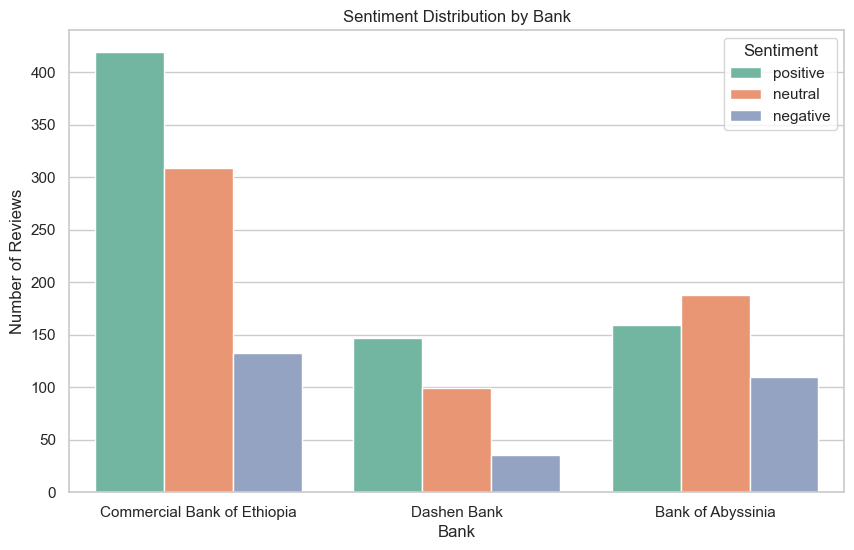

In [15]:
sns.countplot(data=df, x='bank', hue='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()


C:\Users\Dawa Cloud\AppData\Local\Temp\ipykernel_11024\1866955182.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_sentiment, x='bank', y='sentiment_score', palette='coolwarm')


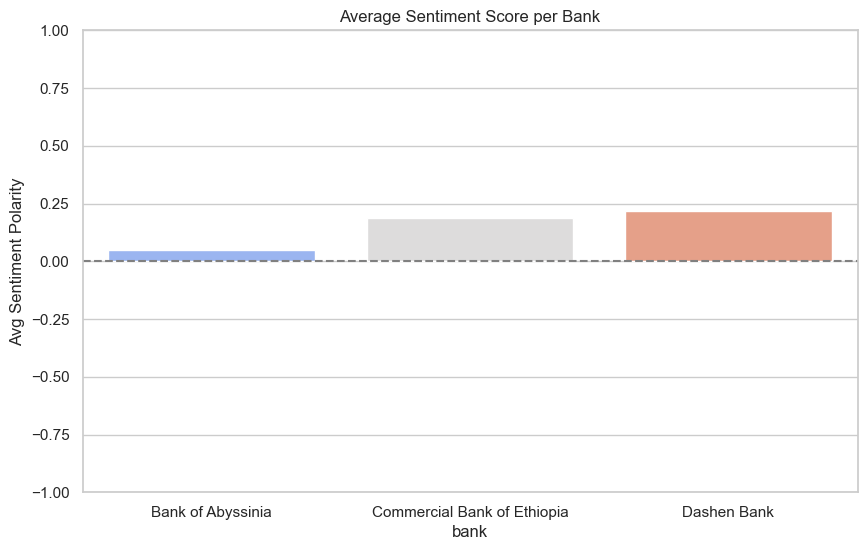

In [16]:
avg_sentiment = df.groupby('bank')['sentiment_score'].mean().reset_index()

sns.barplot(data=avg_sentiment, x='bank', y='sentiment_score', palette='coolwarm')
plt.title('Average Sentiment Score per Bank')
plt.ylabel('Avg Sentiment Polarity')
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.show()


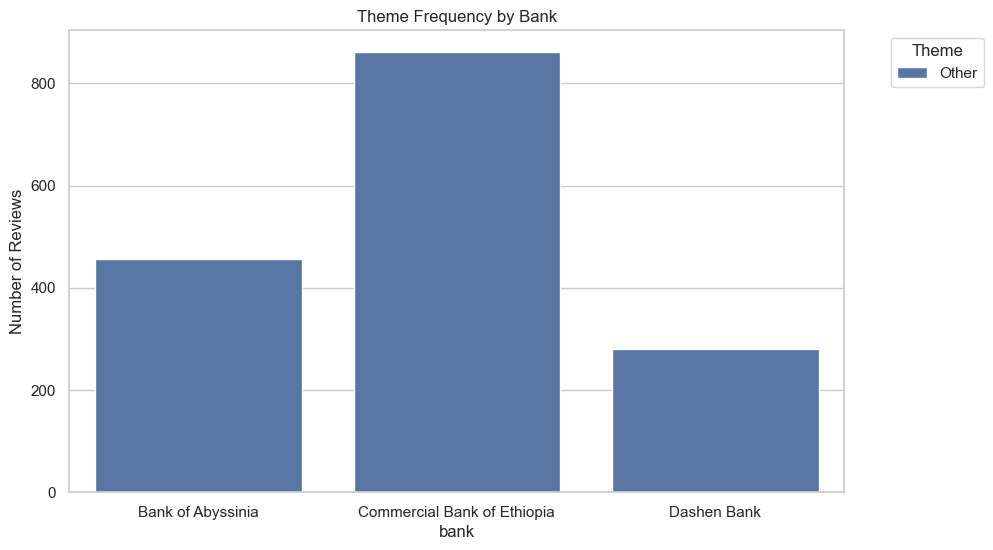

In [17]:
theme_counts = df.groupby(['bank', 'theme']).size().reset_index(name='count')

sns.barplot(data=theme_counts, x='bank', y='count', hue='theme', dodge=True)
plt.title('Theme Frequency by Bank')
plt.ylabel('Number of Reviews')
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


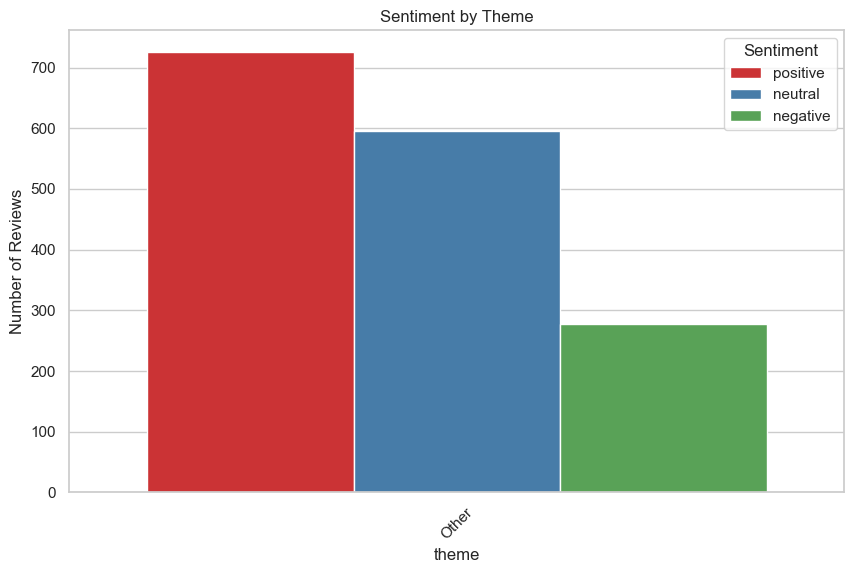

In [18]:
sns.countplot(data=df, x='theme', hue='sentiment_label', palette='Set1')
plt.title('Sentiment by Theme')
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()
